# Wisconsin Diagnostic Breast Cancer

569 instances with breast cancer dignosis (212 malignant, 357 benign) and 30 predictor variables.

See also original [UCI source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

This dataset contains only continuous numeric data and has no missing values.
It allows for very good prediction results without further feature engineering.
Hence, is a good dataset for comparing different binary classification models.

In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()
#print(data['DESCR'])

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'], name='target')
display(X.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Model Training

Train and evaluate following models

* Logistic Regression
* Multi-layer Perceptron
* XGBoost

**Helper functions for visualizing model results:**

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

def show_results(y_true, y_hat, title=None, threshold=0.5, youden=True, report=True):
    
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    axs = axs.ravel()
    
    fpr, tpr, thres = roc_curve(y_test, y_hat)
    if youden:
        threshold = thres[np.where(tpr-fpr == max(tpr-fpr))][0]
    
    # histogram of predicted probabilities
    axs[0].hist([y_hat[y_true==1], y_hat[y_true==0]], stacked=True, label=[1,0], bins=25)
    axs[0].axvline(x=0.5, color='grey', linestyle='--')
    if youden:
        axs[0].axvline(x=threshold, color='r', linestyle='--', label=f'Youden: {threshold:.3f}')
    axs[0].set_title('Predicted Probabilities')
    axs[0].legend(loc='upper center')
    
    # roc curve
    axs[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('FPR')
    axs[1].set_ylabel('TPR')
    axs[1].set_title('ROC (AUC=%0.3f)' % auc(fpr, tpr))
    
    # roc thresholds
    axs[3].plot(thres[1:], 'o--')
    axs[3].set_title('ROC Thresholds')
    
    # confusion_matrix
    cf = pd.crosstab(y_true, y_hat >= threshold, rownames=['Predicted'], colnames=['Actual']).astype(int)
    sns.heatmap(cf, cmap='Blues', annot=True, ax=axs[2], cbar=False, fmt='g')
    axs[2].set_title(f'Confusion Matrix (threshold={threshold:.2f})')
    
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    if report:
        print(classification_report(y_test, y_hat >= threshold))

## Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



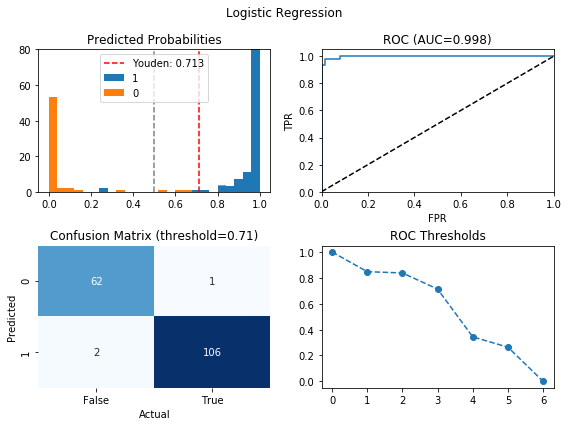

In [5]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)

y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, title="Logistic Regression")

## Multi-layer Perceptron

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

ppl_mlp = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(max_iter=2000))
])

-> took 1.7 seconds


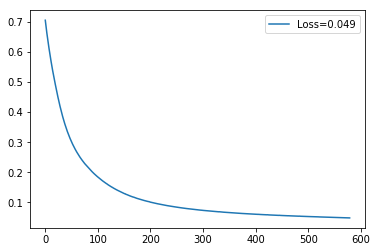

In [7]:
start = time()
ppl_mlp.fit(X_train, y_train)
print('-> took %.1f seconds' % (time() - start))

def show_loss(clf):
    plt.plot(clf.loss_curve_, label=f"Loss={clf.loss_:0.3f}")
    plt.legend()

show_loss(ppl_mlp.named_steps['mlp'])

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



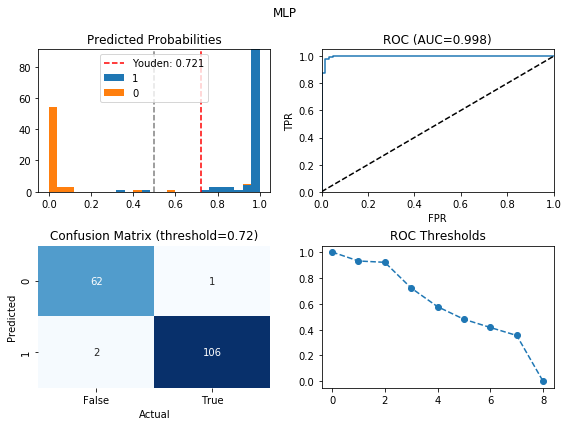

In [8]:
y_hat = ppl_mlp.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, title="MLP")

In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'mlp__hidden_layer_sizes': [ (32), (16), (32, 16), (16, 16) ],
    'mlp__alpha': [ 1e-5, 1e-6 ],
    'mlp__activation': ["logistic", "relu"],
    'mlp__solver' : ['adam', 'sgd'] # sgd is faster but adam is better
}

gs = GridSearchCV(
    estimator=ppl_mlp,
    param_grid=params,
    n_jobs=4,
    cv=10,
    scoring="roc_auc", # neg_log_loss, f1, average_precision, balanced_accuracy
    return_train_score=True,
    iid=False,
    refit=True,
    verbose=1)

start = time()
gs.fit(X_train, y_train)
print('-> took %.1f seconds' % (time() - start))

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:  2.1min finished


-> took 129.7 seconds


In [10]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
4,1.977077,0.352749,0.003339,0.000534,logistic,1e-05,"(32, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.999034,0.995436,0.996635,0.996002,0.996369,0.997168,0.996635,0.996115,0.996463,0.001006
12,2.291595,0.218159,0.004411,0.001750,logistic,1e-06,"(32, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.999300,0.995502,0.995536,0.995802,0.996202,0.997102,0.996335,0.995753,0.996354,0.001078
0,1.664272,0.173150,0.003439,0.000734,logistic,1e-05,32,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.998501,0.995269,0.995402,0.995869,0.995836,0.997368,0.996469,0.995819,0.996194,0.000957
14,2.261411,0.181753,0.004614,0.001436,logistic,1e-06,"(16, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.998901,0.995636,0.995136,0.996202,0.996435,0.997235,0.997102,0.996346,0.996496,0.000996
6,2.048605,0.266030,0.003981,0.000407,logistic,1e-05,"(16, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.998901,0.995336,0.996269,0.995802,0.996502,0.996735,0.997135,0.996444,0.996456,0.000981


{'mlp__activation': 'logistic', 'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (32, 16), 'mlp__solver': 'adam'}


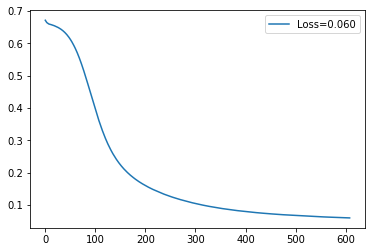

In [11]:
print(gs.best_params_)
gs.best_estimator_.fit(X_train, y_train);
clf = gs.best_estimator_.named_steps['mlp']

show_loss(gs.best_estimator_.named_steps['mlp'])

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.99      1.00      1.00       108

   micro avg       0.99      0.99      0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



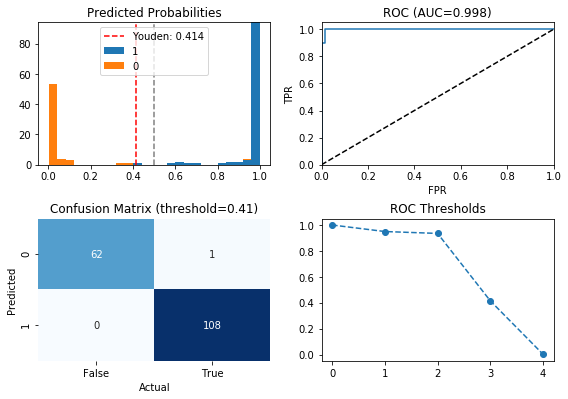

In [12]:
y_hat = gs.best_estimator_.predict_proba(X_test)[:,1]

show_results(y_test, y_hat)